In [ ]:
!unzip 'final_project.zip'

Archive:  final_project.zip
  inflating: Final_Project.tex       
   creating: figures/
  inflating: figures/digits.png      
  inflating: loan.csv                
  inflating: parkinsons.csv          
  inflating: table_results.tgn       
  inflating: titanic.csv             


In [2]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from collections import Counter
import pandas as pd
import math

In [ ]:
titanic_dataset = pd.read_csv('titanic.csv')
titanic_dataset

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [ ]:
titanic_dataset = titanic_dataset.drop(['Name', 'Fare'], axis=1)
titanic_dataset

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0
...,...,...,...,...,...,...
882,0,2,male,27.0,0,0
883,1,1,female,19.0,0,0
884,0,3,female,7.0,1,2
885,1,1,male,26.0,0,0


In [ ]:
titanic_dataset.groupby('Survived').size()

Survived
0    545
1    342
dtype: int64

In [ ]:
titanic_dataset = titanic_dataset.sample(frac=1)
titanic_dataset

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard
609,1,3,female,18.0,1,0
558,0,3,male,40.0,0,0
345,1,3,female,34.0,1,0
410,1,1,female,33.0,1,0
263,0,2,male,36.0,0,0
...,...,...,...,...,...,...
152,0,3,male,40.5,0,2
248,0,2,male,54.0,1,0
20,0,2,male,35.0,0,0
30,0,1,male,40.0,0,0


In [ ]:
titanic_features = titanic_dataset.drop('Survived', axis=1).values
titanic_labels = titanic_dataset['Survived'].values
titanic_features

array([[3, 'female', 18.0, 1, 0],
       [3, 'male', 40.0, 0, 0],
       [3, 'female', 34.0, 1, 0],
       ...,
       [2, 'male', 35.0, 0, 0],
       [1, 'male', 40.0, 0, 0],
       [3, 'female', 15.0, 1, 0]], dtype=object)

In [ ]:
def normalize(train, test, epsilon=1e-10):
    min_val = np.min(train, axis=0)
    max_val = np.max(train, axis=0)
    train_norm = (train - min_val) / (max_val - min_val + epsilon)
    test_norm = (test - min_val) / (max_val - min_val + epsilon)
    return train_norm, test_norm

In [ ]:
numerical_indices = [2, 3, 4]
categorical_indices = [0, 1]
X_numerical = np.array(titanic_features[:, numerical_indices], dtype=float)
X_categorical = titanic_features[:, categorical_indices]
feature_encoder = OneHotEncoder(sparse=False)
X_categorical_encoded = feature_encoder.fit_transform(X_categorical)
X_numerical_normalized, _ = normalize(X_numerical, X_numerical)
X = np.hstack((X_numerical_normalized, X_categorical_encoded))
label_encoder = OneHotEncoder(sparse=False)
y = label_encoder.fit_transform(titanic_labels.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def stratified_cross_validation(features, labels, k=10):
    label_indices = [np.where(labels == label)[0] for label in np.unique(labels)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

Question 1. Evaluate the performance of at least two algorithms you studied and/or implemented during the semester (e.g., k-NN, Decision Trees, standard Naive Bayes, Random Forests, Neural Networks, etc).1 You should discuss which algorithms you decided to test on each dataset and why.

# Neural Network Algorithm

Please note that we used Cyril's implementation of NN here.

In [ ]:
class NN:
    def __init__(self, sizes, initial_weights=None, eta=0.01, reg_lambda=0.01, use_softmax=False):
        self.sizes = sizes
        self.eta = eta
        self.reg_lambda = reg_lambda
        self.use_softmax = use_softmax
        self.weights = self.init_weights() if initial_weights is None else initial_weights

    def init_weights(self):
        return [np.random.randn(y, x + 1) * 0.1 for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        act = [self.add_bias(X)]
        ll = []
        for index, weight in enumerate(self.weights[:-1]):
            ll.append(act[-1] @ weight.T)
            act.append(self.add_bias(1 / (1 + np.exp(-ll[-1]))))
        ll.append(act[-1] @ self.weights[-1].T)
        act.append(self.softmax(ll[-1]) if self.use_softmax else 1 / (1 + np.exp(-ll[-1])))
        return act, ll

    def cost(self, Y, act):
        xq = Y.shape[0]
        return -np.sum(Y * np.log(act[-1] + 1e-8)) / xq if self.use_softmax else -np.sum(Y * np.log(act[-1]) + (1 - Y) * np.log(1 - act[-1])) / xq

    def backward(self, targets, activations, weights):
        num_samples = targets.shape[0]
        errors = [activations[-1] - targets]
        gradients = []
        for i in range(len(weights) - 1, 0, -1):
            delta = (errors[0] @ weights[i][:, 1:]) * activations[i][:, 1:] * (1 - activations[i][:, 1:])
            errors.insert(0, delta)
        for i in range(len(weights)):
            grad = errors[i].T @ activations[i] / num_samples
            gradients.append(grad)
        return errors, gradients

    def update_weights(self, gradients):
        for i in range(len(self.weights)):
            regularization_grad = (self.reg_lambda * self.weights[i]) / self.weights[i].shape[0]
            regularization_grad[:, 0] = 0
            self.weights[i] -= self.eta * (gradients[i] + regularization_grad)

    def predict(self, inputs):
        final_activations, _ = self.forward(inputs)
        return np.argmax(final_activations[-1], axis=1) + 1

    def train(self, inputs, labels, iterations):
        for _ in range(iterations):
            final_activations, _ = self.forward(inputs)
            _, weight_gradients = self.backward(labels, final_activations, self.weights)
            self.update_weights(weight_gradients)
        return self.weights


In [ ]:
def accuracy(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    accuracy = np.mean(predictions == true_labels)
    return accuracy * 100

def f1_score(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    classes = np.unique(true_labels)
    f1_scores = []
    for c in classes:
        tp = np.sum((predictions == c) & (true_labels == c))
        fp = np.sum((predictions == c) & (true_labels != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fn = np.sum((predictions != c) & (true_labels == c))
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores) * 100
    return avg_f1

In [ ]:
nn = NN([X.shape[1], 16, 2], eta=0.05, reg_lambda=0.01, use_softmax=True)
trained_weights = nn.train(X_train, y_train, iterations=20000)
train_predictions = nn.predict(X_train)
train_accuracy = accuracy(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}%")
test_predictions = nn.predict(X_test)
test_accuracy = accuracy(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 81.10%
Testing Accuracy: 78.65%


In [ ]:
def test_hyperparameters(features, labels, k=10):
    eta_values = [0.05, 0.1, 0.2]
    reg_lambda_values = [0.01, 0.05, 0.1]
    layer_configurations = [
        [X.shape[1], 16, 2] ,
        [X.shape[1], 32, 2],
        [X.shape[1], 16, 16, 2],
        [X.shape[1], 32, 32, 2]
    ]
    results = []
    for eta in eta_values:
        for reg_lambda in reg_lambda_values:
            for layers in layer_configurations:
                train_accuracies = []
                train_f1_scores = []
                test_accuracies = []
                test_f1_scores = []
                splits = stratified_cross_validation(features, labels, k)
                for train_indices, test_indices in splits:
                    X_train, y_train = features[train_indices], labels[train_indices]
                    X_test, y_test = features[test_indices], labels[test_indices]
                    nn = NN(layers, eta=eta, reg_lambda=reg_lambda, use_softmax=True)
                    nn.train(X_train, y_train, iterations=1000)
                    train_predictions = nn.predict(X_train)
                    train_accuracy = accuracy(y_train, train_predictions)
                    train_f1 = f1_score(y_train, train_predictions)
                    test_predictions = nn.predict(X_test)
                    test_accuracy = accuracy(y_test, test_predictions)
                    test_f1 = f1_score(y_test, test_predictions)
                    train_accuracies.append(train_accuracy)
                    train_f1_scores.append(train_f1)
                    test_accuracies.append(test_accuracy)
                    test_f1_scores.append(test_f1)
                results.append({
                    "configuration": layers,
                    "lambda": reg_lambda,
                    "learning_rate": eta,
                    "train_accuracy": np.mean(train_accuracies),
                    "train_f1": np.mean(train_f1_scores),
                    "test_accuracy": np.mean(test_accuracies),
                    "test_f1": np.mean(test_f1_scores)
                })
    return results


I decided not to use all features in the dataset. I ended up dropping the Name and Fare columns because I don't think the learning algorithm will benefit from either of these two information. A person's name doesn't play a role in their survival on the titanic and same with the fare price, I don't see how the price of their ticket will affect them surviving or not. There isn't in my opinion a correlation between Fare price and survival.

I left pclass since their location/class on the boat could've played a role in them accessing certain resources faster or getting help faster.

I read somewhere that women were more likely to survive than men on the titanic this might be due to the "women and children first" rule this is why I decided to keep 'Sex' since it can be a good indicative of survival. Same reasoning with age: children were more likely to be saved in life-threatening situations and the elderly may have had lower survival rates due to physical constraints.

For 'Siblings/Spouses Aboard' the presence of spouses or siblings might have affected an individual’s survival probability, for instance some individuals might have waited for their relatives during evacuations, influencing their chances of securing a place in a lifeboat.

For 'Parents/Children Aboard' Families with children might have been given priority in rescue efforts, potentially increasing their survival rates. Large families might have faced difficulties in securing space for all members, affecting their decisions and outcomes during the disaster.

I decide to use the NN algorithm here because:

Neural networks are  good at capturing complex, non-linear interactions between features which is useful here with this dataset where interactions between features like 'Age', 'Sex', 'Pclass', and 'Siblings/Spouses Aboard' might not be straightforward.

While NNs require numerical input, categorical data can be effectively incorporated using techniques like one-hot encoding unlike other algorithms that we've seen in class. This makes NNs a good option for datasets that mix numerical and categorical attributes.

In [ ]:
results_nn = test_hyperparameters(X, y, k=10)
for result in results_nn:
    print(f"Structure: {result['configuration']}, Lambda: {result['lambda']}, Learning Rate: {result['learning_rate']}, "
          f"Train Acc: {result['train_accuracy']:.2f}, Train F1: {result['train_f1']:.2f}, Test Acc: {result['test_accuracy']:.2f}, "
          f"Test F1: {result['test_f1']:.2f}")

Structure: [8, 16, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 78.58, Train F1: 77.02, Test Acc: 78.58, Test F1: 77.00
Structure: [8, 32, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 78.58, Train F1: 77.02, Test Acc: 78.57, Test F1: 76.93
Structure: [8, 16, 16, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 61.44, Train F1: 38.06, Test Acc: 61.45, Test F1: 38.02
Structure: [8, 32, 32, 2], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 61.44, Train F1: 38.06, Test Acc: 61.43, Test F1: 38.03
Structure: [8, 16, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 78.58, Train F1: 76.45, Test Acc: 77.79, Test F1: 75.65
Structure: [8, 32, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 78.58, Train F1: 77.02, Test Acc: 78.58, Test F1: 76.93
Structure: [8, 16, 16, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 61.44, Train F1: 38.06, Test Acc: 61.45, Test F1: 38.02
Structure: [8, 32, 32, 2], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 61.44, Train F1: 38.06, Test Acc: 61.45,

In [ ]:
def display_sorted_results(results):
    df = pd.DataFrame(results)
    sort_columns = ['test_accuracy', 'test_f1']
    sorted_df = df.sort_values(by=sort_columns, ascending=[False, False])
    print(sorted_df.to_string(index=False))

display_sorted_results(results_nn)

 configuration  lambda  learning_rate  train_accuracy  train_f1  test_accuracy   test_f1
    [8, 16, 2]    0.01           0.20       79.287243 77.638050      79.087079 77.390717
    [8, 32, 2]    0.01           0.20       79.093188 77.480802      78.695735 77.017387
[8, 32, 32, 2]    0.01           0.20       78.592100 77.031385      78.586568 76.930515
    [8, 16, 2]    0.05           0.10       78.579568 77.019228      78.586568 76.892741
    [8, 32, 2]    0.01           0.10       78.579537 77.019743      78.584014 76.910245
    [8, 16, 2]    0.05           0.20       78.579529 77.020329      78.583376 76.979525
    [8, 32, 2]    0.05           0.10       78.579514 77.020472      78.582099 76.981829
    [8, 32, 2]    0.05           0.05       78.579514 77.019773      78.582099 76.926013
    [8, 16, 2]    0.10           0.20       78.579498 77.020081      78.580822 76.952070
    [8, 32, 2]    0.10           0.20       78.579482 77.020357      78.579545 76.971679
    [8, 16, 2]    0.0

The neural network with the configuration [8, 16, 2] and hyperparameters lambda = 0.01 and learning rate = 0.20 appears to be the most effective, achieving the highest test accuracy and F1 score.
The simpler two-layer configurations [8, 16, 2] and [8, 32, 2]consistently outperform the more complex three-layer configurations [8, 16, 16, 2] and [8, 32, 32, 2], especially at higher training complexities this suggests that for this dataset and neural network setup, simpler models with adequately tuned hyperparameters moderate learning rates and low lambda values tend to perform better.








**5.** For each dataset, and considering the best hyper-parameter setting for each selected algorithm, construct
relevant learning curves and/or graphs. These should be similar to the learning curves/graphs you
constructed in the homework relevant to the particular algorithm you are evaluating. For example, if
you choose to deploy a Random Forest to tackle one of the datasets, construct a graph relating its
performance and the number of trees in the ensemble; if you choose to use a neural network, construct
a learning curve showing the value of the cost function, J, as a function of the number of training
instances presented to the network. Assuming that you evaluate two algorithms on each of the four
datasets, these analyses should result in (at least) 8 graphs. Briefly discuss and interpret these graphs.
For example: Why do you think a particular algorithm may be converging to a poor local optimum
when deployed on a given dataset? Why do you think a specific algorithm performs better on datasets
containing only numerical attributes? and so on

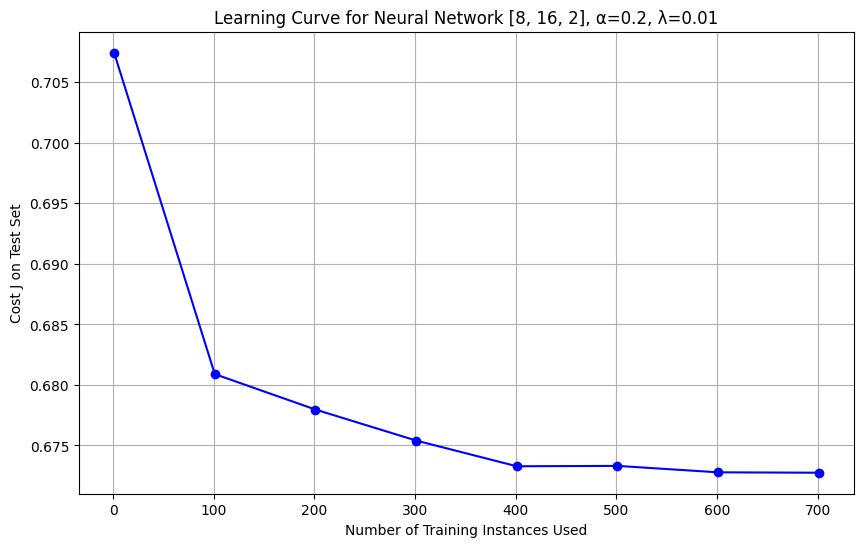

In [ ]:
def learning_curve(X_train, y_train, X_test, y_test, nn, increments=100):
    costs = []
    for i in range(1, len(X_train), increments):
        nn.train(X_train[:i], y_train[:i], iterations=1)
        activations, _ = nn.forward(X_test)
        cost = nn.cost(y_test, activations[-1])
        costs.append(cost)
    return costs

np.random.seed(0)
nn = NN([8, 16, 2], eta=0.2, reg_lambda=0.01, use_softmax=True)
costs = learning_curve(X_train, y_train, X_test, y_test, nn)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train), 100), costs, marker='o', linestyle='-', color='b')
plt.title('Learning Curve for Neural Network [8, 16, 2], α=0.2, λ=0.01')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Cost J on Test Set')
plt.grid(True)

As the number of instances increases the value of the cost function J decreases converging to 0.675 almost (lower bound):

As the number of training instances increases the neural network begins to capture more comprehensive information about the data distribution this reduces the variance in the estimate of the model's parameters. The model's weights and biases converge towards values that generalize better over the entire data distribution.

With fewer training instances a neural network is more prone to overfitting but as we increase the number of training instances each noise has less influence on the overall learning process which generally leads to a reduction in overfitting allowing the model to learn more generalizable patterns that is reflected in the decreasing cost function J.

With more data, the gradient descent process can estimate the gradient of the cost function more accurately because it has more examples. This helps the network find a lower minimum of the cost function.

As more training data becomes available the model learns to recognize underlying patterns in the data better, which helps in reducing the cost.

The convergence of the cost function J to about 0.675 suggests that the model is approaching a steady state where adding more training instances does not significantly change the outcome. This steady state might be the best achievable performance given the current model architecture and hyperparameter settings.

# Random Forests

Please note that we used Cyril's implementation of Random Forests here.

In [ ]:
def feature_type(dataset):
    feature_types = {}
    feature_descriptions = {
        'Pclass': 'categorical',
        'Sex': 'categorical',
        'Age': 'numerical',
        'Siblings/Spouses Aboard': 'numerical',
        'Parents/Children Aboard': 'numerical',
    }
    for column in dataset.columns:
        if column == 'Survived':
          continue
        if column in feature_descriptions:
            feature_types[column] = feature_descriptions[column]
        else:
            raise ValueError(f"{column} does not exist")
    return feature_types

titanic_feature_types = feature_type(titanic_dataset)
print(titanic_feature_types)


{'Pclass': 'categorical', 'Sex': 'categorical', 'Age': 'numerical', 'Siblings/Spouses Aboard': 'numerical', 'Parents/Children Aboard': 'numerical'}


In [ ]:
class DT:
    def __init__(self, max_depth=20, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def entropy(self, labels):
        label, counts = np.unique(labels, return_counts=True)
        prob = counts / counts.sum()
        return -np.sum(prob * np.log2(prob))

    def information_gain_numerical(self, labels, true_labels, false_labels):
        prob = float(len(true_labels)) / len(labels)
        info_gain = self.entropy(labels) - prob * self.entropy(true_labels) - (1 - prob) * self.entropy(false_labels)
        return info_gain

    def information_gain_categorical(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        avg_entropy_of_partitions = sum((counts[i] / sum(counts)) * self.entropy(labels[partitions == value]) for i, value in enumerate(values))
        return self.entropy(labels) - avg_entropy_of_partitions

    def best_split(self, features, labels, feature_types, min_info_gain=0.01):
        best_gain = -np.inf
        best_feature = None
        best_split_val = None
        m = int(math.sqrt(len(features.columns)))
        m_features = np.random.choice(features.columns, m, replace=False)
        for feature in m_features:
            if feature_types[feature] == "categorical":
                info_gain = self.information_gain_categorical(labels, features[feature])
                if info_gain > best_gain and info_gain >= min_info_gain:
                    best_gain, best_feature = info_gain, feature
                    best_split_val = None
            else:
                sorted_indices = features[feature].sort_values().index
                sorted_labels = labels.loc[sorted_indices]
                sorted_features = features.loc[sorted_indices, feature]
                for i in range(1, len(sorted_features)):
                    if sorted_features.iloc[i] == sorted_features.iloc[i - 1]:
                        continue
                    split_val = (sorted_features.iloc[i] + sorted_features.iloc[i - 1]) / 2
                    true_labels = sorted_labels[sorted_features <= split_val]
                    false_labels = sorted_labels[sorted_features > split_val]
                    info_gain = self.information_gain_numerical(labels, true_labels, false_labels)
                    if info_gain > best_gain and info_gain >= min_info_gain:
                        best_gain, best_feature, best_split_val = info_gain, feature, split_val
        return best_feature, best_split_val

    def build_dt(self, features, labels, feature_types, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or (self.max_depth and depth >= self.max_depth):
            return np.unique(labels)[0]
        else:
            best_feature, best_split_val = self.best_split(features, labels, feature_types)
            if best_feature is None:
                return np.unique(labels)[np.argmax(np.unique(labels, return_counts=True)[1])]
            tree = {best_feature: {}}
            if best_split_val is None:
                for value in np.unique(features[best_feature]):
                    subtree_features = features[features[best_feature] == value].drop(columns=[best_feature])
                    subtree_labels = labels[features[best_feature] == value]
                    subtree = self.build_dt(subtree_features, subtree_labels, feature_types, depth + 1)
                    tree[best_feature][value] = subtree
            else:
                left_indices = features[best_feature] <= best_split_val
                right_indices = features[best_feature] > best_split_val
                left_subtree = self.build_dt(features[left_indices], labels[left_indices], feature_types, depth + 1)
                right_subtree = self.build_dt(features[right_indices], labels[right_indices], feature_types, depth + 1)
                tree[best_feature] = {"<= {:.2f}".format(best_split_val): left_subtree , "> {:.2f}".format(best_split_val): right_subtree}
            return tree

    def fit(self, features, labels, feature_types):
        self.feature_types = feature_types
        self.tree = self.build_dt(features, labels, feature_types)

    def predict(self, dataset):
        predictions = []
        for _, instance in dataset.iterrows():
            prediction = self.predict_helper(instance, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = next(iter(tree))
        if self.feature_types[feature] == 'categorical':
            if instance[feature] in tree[feature]:
                return self.predict_helper(instance, tree[feature][instance[feature]])
        else:
            for key, subtree in tree[feature].items():
                if key.startswith('<='):
                    split_val = float(key.split('<= ')[1])
                    if instance[feature] <= split_val:
                        return self.predict_helper(instance, subtree)
                elif key.startswith('>'):
                    split_val = float(key.split('> ')[1])
                    if instance[feature] > split_val:
                        return self.predict_helper(instance, subtree)
                else:
                    if instance[feature] == key:
                        return self.predict_helper(instance, subtree)
        return np.nan


In [ ]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=20, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def bootstrap(self, features, labels):
        num_samples = features.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=True)
        return features.iloc[indices], labels.iloc[indices]

    def fit(self, features, labels, feature_types):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DT(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            features_sample, labels_sample = self.bootstrap(features, labels)
            tree.fit(features_sample, labels_sample, feature_types)
            self.trees.append(tree)

    def predict(self, instances):
        tree_preds = [tree.predict(instances) for tree in self.trees]
        tree_preds = np.array(tree_preds).T
        majority_votes = [self.most_common_label(pred) for pred in tree_preds]
        return np.array(majority_votes)

    def most_common_label(self, pred):
        return Counter(pred).most_common(1)[0][0]

In [ ]:
def unique_labels_filter(true_labels):
    filtered_labels = [label for label in true_labels if not np.isnan(label)]
    return np.unique(filtered_labels)

def mc_cm(true_labels, predictions, num_classes):
    unique_labels = unique_labels_filter(true_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for true, pred in zip(true_labels, predictions):
        if np.isnan(pred):
            continue
        true_idx = label_to_index[true]
        pred_idx = label_to_index.get(pred, -1)
        if pred_idx != -1:
            confusion_matrix[true_idx][pred_idx] += 1
    return confusion_matrix

def metrics_calc(confusion_matrix):
    metrics = {'precision': [], 'recall': [], 'f1': []}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i][i]
        FN = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)
        FP = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        TN = sum(sum(confusion_matrix[j][k] for k in range(len(confusion_matrix)) if k != i) for j in range(len(confusion_matrix)) if j != i)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
    for metric in metrics:
        metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
    return metrics


In [ ]:
def evaluate_rf(features, labels, feature_types, k=10, ntree=1):
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    pairs = stratified_cross_validation(features, labels, k=k)
    num_classes = len(np.unique(labels))
    for train_indices, test_indices in pairs:
        features_train, labels_train = features.iloc[train_indices], labels.iloc[train_indices]
        features_test, labels_test = features.iloc[test_indices], labels.iloc[test_indices]
        ensemble = RandomForest(n_trees=ntree, max_depth=10, min_samples_leaf=1)
        ensemble.fit(features_train, labels_train, feature_types)
        predictions = ensemble.predict(features_test)
        confusion_matrix = mc_cm(labels_test.to_numpy(), predictions, num_classes)
        metrics = metrics_calc(confusion_matrix)
        accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / sum(sum(row) for row in confusion_matrix)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(metrics['precision'])
        scores['recall'].append(metrics['recall'])
        scores['f1'].append(metrics['f1'])
    avg_perf = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_perf

In [ ]:
titanic_features_df = pd.DataFrame(titanic_features, columns=['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard'])
titanic_labels_df = pd.Series(titanic_labels)
average_performance_rf1 = evaluate_rf(titanic_features_df, titanic_labels_df, titanic_feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_rf1}")

Metrics for a value of ntree = 1: {'accuracy': 0.7963548034520166, 'precision': 0.7934550691005396, 'recall': 0.7718955157967367, 'f1': 0.777143935988298}


In [ ]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(titanic_features_df, titanic_labels_df, titanic_feature_types, k=10, ntree=ntree)
    metrics_results['ntree'].append(ntree)
    metrics_results['accuracy'].append(average_performance['accuracy'])
    metrics_results['precision'].append(average_performance['precision'])
    metrics_results['recall'].append(average_performance['recall'])
    metrics_results['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")


Metrics for a value of ntree = 1: {'accuracy': 0.7890265009647033, 'precision': 0.7910630709092242, 'recall': 0.7626967150496563, 'f1': 0.7687359483139742}
Metrics for a value of ntree = 5: {'accuracy': 0.8036820451708092, 'precision': 0.8174521249629192, 'recall': 0.7691757915287327, 'f1': 0.7784630063814352}
Metrics for a value of ntree = 10: {'accuracy': 0.8085299625468165, 'precision': 0.8151488317689568, 'recall': 0.7767023172905525, 'f1': 0.7863456848943885}
Metrics for a value of ntree = 20: {'accuracy': 0.8138710135058449, 'precision': 0.8222332455921159, 'recall': 0.7841880994822172, 'f1': 0.7932563406196731}
Metrics for a value of ntree = 30: {'accuracy': 0.8116473726024289, 'precision': 0.828053585601225, 'recall': 0.7781635684576862, 'f1': 0.7873013477002545}
Metrics for a value of ntree = 40: {'accuracy': 0.8161931108841222, 'precision': 0.8229748259677645, 'recall': 0.7861238434767845, 'f1': 0.7961130686672309}
Metrics for a value of ntree = 50: {'accuracy': 0.80808903643

I decided to use Random Forests as my seconf algorithm because:

Random Forests can handle both Numerical and Categorical Data without the need for extensive preprocessing this is beneficial in this case where our dataset contains both types.

The ensemble method of combining multiple decision trees make random forests less likely to overfit compared to single decision trees. This is useful cosidering the limited size of the Titanic dataset.

Random forests provide insights into feature importance, which can be valuable for understanding which attributes (like 'Sex' or 'Pclass') are most predictive of survival.

They often produce good results with default parameters and are less sensitive to the specific tuning of parameters compared to other algorithms like neural networks.

**Question 4.** Given the observation above, you should first show, in a table, the performance of each algorithm
(on a given dataset) under a few selected hyper-parameters. You should evaluate at least 3 hyperparameter settings. After analyzing the performance of each algorithm under different hyper-parameters,
identify the best hyper-parameter setting—that is, the set of hyper-parameters that resulted in the best
performance for the corresponding algorithm on a particular dataset.

In [3]:
rf_data = {
    'ntree': [1, 5, 10, 20, 30, 40, 50],
    'accuracy': [0.7890, 0.8037, 0.8085, 0.8139, 0.8116, 0.8162, 0.8081],
    'precision': [0.7911, 0.8175, 0.8151, 0.8222, 0.8281, 0.8230, 0.8133],
    'recall': [0.7627, 0.7692, 0.7767, 0.7842, 0.7782, 0.7861, 0.7761],
    'f1': [0.7687, 0.7785, 0.7863, 0.7933, 0.7873, 0.7961, 0.7852]
}
rf_df = pd.DataFrame(rf_data)
rf_df['max_depth'] = 20
rf_df['min_samples_leaf'] = 1
print(rf_df)

   ntree  accuracy  precision  recall      f1  max_depth  min_samples_leaf
0      1    0.7890     0.7911  0.7627  0.7687         20                 1
1      5    0.8037     0.8175  0.7692  0.7785         20                 1
2     10    0.8085     0.8151  0.7767  0.7863         20                 1
3     20    0.8139     0.8222  0.7842  0.7933         20                 1
4     30    0.8116     0.8281  0.7782  0.7873         20                 1
5     40    0.8162     0.8230  0.7861  0.7961         20                 1
6     50    0.8081     0.8133  0.7761  0.7852         20                 1


The configuration that performed best in terms of accuracy and F1 score is: ntree=40 and I'm using two stopping criterions max_depth=20 and min_samples_leaf=1. This combination not only provided one of the highest accuracies but also balanced other metrics effectively.

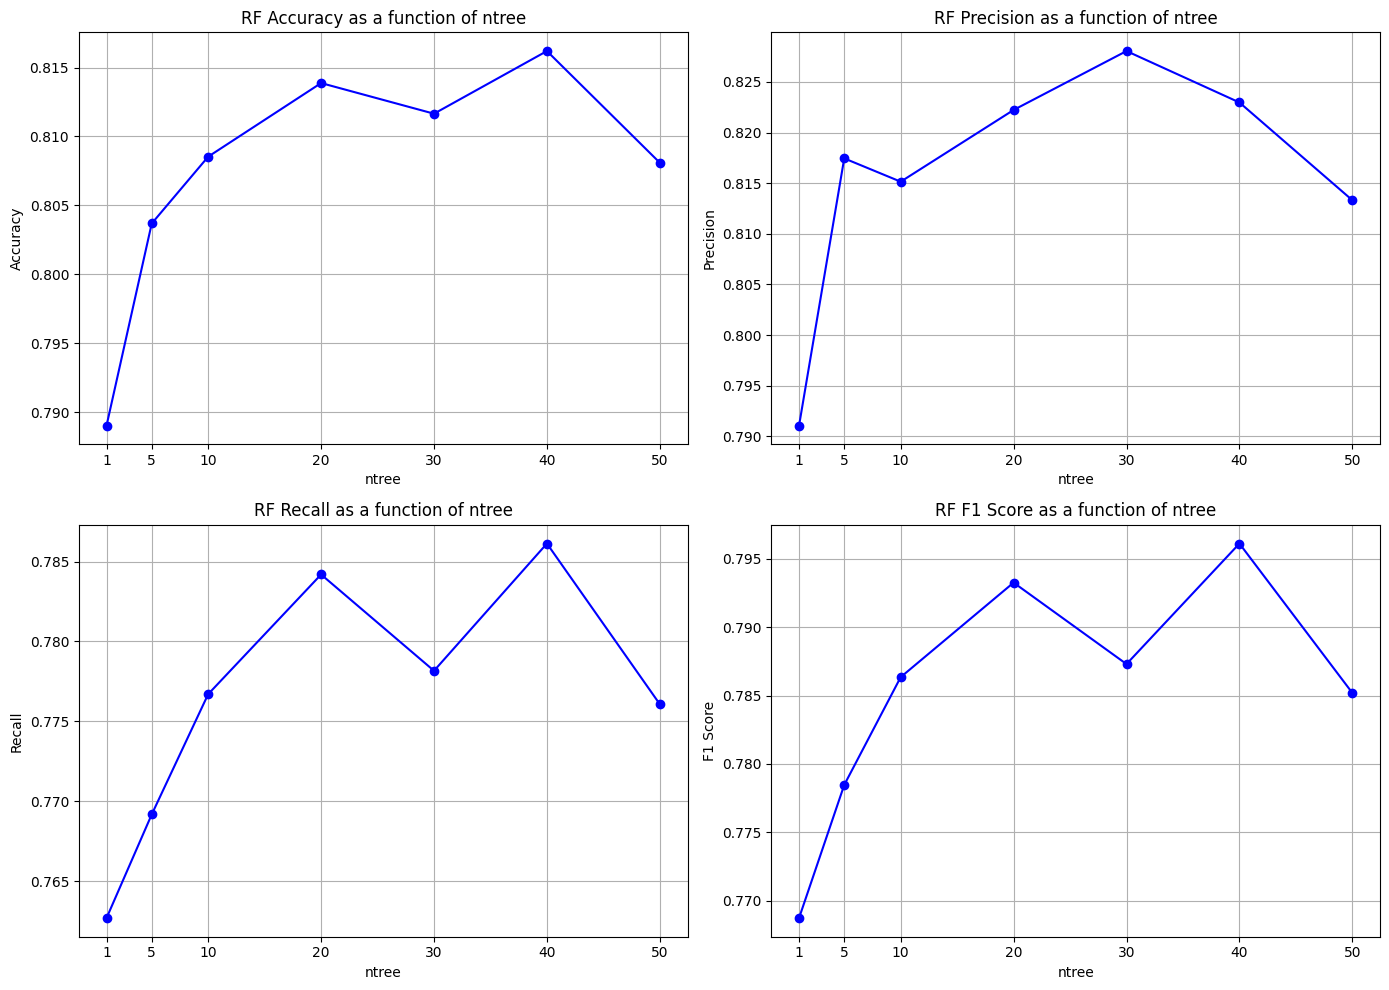

In [ ]:
def plot(metrics):
    plt.figure(figsize=(14, 10))
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], start=1):
        plt.subplot(2, 2, i)
        plt.plot(metrics['ntree'], metrics[metric], marker='o', linestyle='-', color='b')
        plt.title(f'RF {titles[i-1]} as a function of ntree')
        plt.xlabel('ntree')
        plt.ylabel(titles[i-1])
        plt.xticks(metrics_results['ntree'])
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot(metrics_results)

Accuracy was observed to peak at ntree = 40 with a score around 0.815. After this point, increasing the number of trees seem to affect accuracy in a negative way (decreasing ). Hence for
40 the model’s ability to correctly classify instances is the best. Accuracy is important because it provides us with a general measure of how often the classifier is correct across both classes. Given that accuracy is and considering computational efficiency, ntree=40
appears to be a well-rounded choice for general purposes.

The F1 score, which balances precision and recall, peaked at ntree = 40 with a score around 0.795. Hence, ntree = 40 is indeed the best choice in this case: it ensures a balanced and fair tradeoff
between precision and recall.
To sum up, based on the analysis, ntree = 40 is the recommended value for deploying this classifier. This choice is supported by the somewhat highest performance across all evaluated metrics.
Further increases in ntree may not justify the marginal gains across the metrics due to increased computational demand and even decrease in performance. Using too many trees >40 in this context risks overfitting, where the model becomes too complex, capturing noise making the model less generalizable